## TODO actually can't just select the exposure regions for each country because the population weighting won't be normalised. Instead, have to select the population then multi by the anomaly and normalise by the selected population, rather than the global one.

7 countries

6 page long policy briefs


USA
UK

EU (28)

India
France

1.1
USA
India
France

1.2
UK
USA (Hawaii? Alaska? -> check with country author)
EU(28) (Exclude oversees)
India
France
Sweden

1.3
India


Excel spreadsheet

Columns -> countries
Rows -> years

Generate plots anyways

Generate maps


In [4]:
%matplotlib inline

from pathlib import Path
from datetime import date

import rasterio
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas
import affine
import fiona

from scipy import stats
from tqdm import tnrange, tqdm_notebook, tqdm


import weather_ecmwf
import population_tools

from config import (DATA_SRC, ERA_MONTHLY_FILE, 
                    CLIMATOLOGY_FILE_MONTHLY, POP_DATA_SRC)

In [2]:
from joblib import Parallel, delayed

In [3]:
COUNTRY_BRIEFS = Path('./country_briefs')

In [10]:
pop =  population_tools.PopulationProjector('population_count_2000-2020.nc', mask_empty=True)

## Age percentage rasters

In [16]:
pct_age_rasters = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'population_over_65.nc'))
pct_age_rasters

<xarray.DataArray 'pop_over_65' (latitude: 2175, longitude: 5400, year: 17)>
[199665000 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 85.0 84.93 84.87 84.8 84.73 84.67 84.6 ...
  * longitude  (longitude) float64 0.0 0.06667 0.1333 0.2 0.2667 0.3333 0.4 ...
  * year       (year) int64 2000 2001 2002 2003 2004 2005 2006 2007 2008 ...

In [3]:
# pct_age_rasters = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'population_over_65_b.nc'))

## Load country data

In [19]:
countries = geopandas.read_file(str(DATA_SRC / 'GIS' / 'world' / 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'))

countries.loc[countries.iso_a2 == '-99', 'iso_a2'] = None
countries['index_number'] = countries.index  + 1
# countries.set_index('iso_')

### Define functions


In [17]:
def do_selection(row, data, country_da):
    country_num = row.index_number
    selection = data.where(country_da == country_num)
    selection_ts = selection.mean(dim=['latitude', 'longitude'])
    selection_ts.name = row.iso_a2
    selection_ts = selection_ts.to_dataframe()
    return selection_ts

def get_template(data):
    template = data.sel(year=2000).copy()
    template = template.drop('year')
    return template

def rasterize_countries(countries, target_data):
    country_raster = get_template(target_data)

    base_affine = population_tools.get_affine(country_raster)

    _country_raster = rasterio.features.rasterize(
        [(g, v) for v, g in countries.set_index('index_number').geometry.iteritems()],
        country_raster.shape,
        transform=affine.Affine.translation(-180, 0) * base_affine,
    )

    country_raster.name = 'countries_id'
    country_raster.values = np.roll(_country_raster, -_country_raster.shape[1] // 2, axis=1)
    return country_raster

def rasterize_eu(countries, target_data):
    country_raster = get_template(target_data)

    base_affine = population_tools.get_affine(country_raster)

    _country_raster = rasterio.features.rasterize(countries.geometry.values, 
                                          country_raster.shape,
                                          transform=affine.Affine.translation(-180, 0) * base_affine,
                                          fill=0,
                                 default_value=1
                                        )

    country_raster.values = np.roll(_country_raster, -_country_raster.shape[1] // 2, axis=1)
    return country_raster


## 1.1 Heatwave change

### Load data


In [12]:
heatwaves_counts = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc'))
heatwaves_lengths = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

In [13]:
heatwaves_counts_historical = heatwaves_counts.sel(year=slice(1986,2008)).mean(dim='year')
heatwaves_counts_delta = heatwaves_counts.sel(year=slice(2000,2017)) - heatwaves_counts_historical

heatwaves_lengths_historical = heatwaves_lengths.sel(year=slice(1986,2008)).mean(dim='year')
heatwaves_lengths_delta = heatwaves_lengths.sel(year=slice(2000,2017)) - heatwaves_lengths_historical

In [14]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwaves_lengths.latitude))
heatwaves_counts_ts = (heatwaves_counts_delta * cos_lat).mean(dim=['latitude', 'longitude'])
heatwaves_lengths_ts = (heatwaves_lengths_delta * cos_lat).mean(dim=['latitude', 'longitude'])



### Heatwave by country

TODO need to figure out what to do about latitude weighting? Problem is that when you take a subset of the global, the weights no longer sum to 1. Could simply assume that the difference across a single country isn't going to be be big enough to make this an issue.

In [20]:
countries_raster_anom = rasterize_countries(countries, heatwaves_counts_delta)

In [21]:
results = [do_selection(row, heatwaves_counts_delta, countries_raster_anom) 
           for idx, row in tqdm(countries.iterrows(), total=len(countries)) if row.iso_a2]

anom_by_country = pd.concat(results, axis=1)

100%|██████████| 241/241 [00:05<00:00, 42.12it/s]


### Exposures by country


For Heatwaves, want the same plots as were in the original paper

- the heatwave exposure total number change (not normalised)
- the heatwave length change


UK

USA

India

France

Sweden

In [22]:
select_country = ['IN', 'US', 'GB', 'FR', 'SE', 'AU']
select_country_a3 = ['IND', 'USA', 'GBR', 'FRA', 'SWE', 'AUS']

In [23]:
def _project_to_population(anom_data, country_da, country_num, norm=True):
    country_da = country_da.copy()
    country_da.shape = (*country_da.shape, 1)
    
#     with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
    with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                              'water_mask_eightres.tif',
                                             ) as pop:


        pop_sel = (pop.data * pct_age_rasters).where(country_da == country_num).compute()
        pop_sum = pop_sel.sum(dim=['latitude', 'longitude'], skipna=True)

        def do():
            proj = pop.project_param(anom_data.sel(year=year))
            proj = proj * pop_sel.sel(year=year)
            if norm:
                proj = proj / pop_sum.sel(year=year)
            proj.compute()
            return proj
        
        exposures = xr.concat((do() for year in range(2000,2017)), dim='year')   
        exposures_ts = (exposures ).sum(dim=['latitude', 'longitude'], 
                                                 skipna=True).compute()
        return exposures_ts
    
def do_exposure(row, data, country_da, norm=True):
    country_num = row.index_number
    exposures_ts = _project_to_population(data, country_da, country_num, norm=norm)
    exposures_ts.name = row.iso_a2
    exposures_ts = exposures_ts.to_dataframe()
    return exposures_ts

In [24]:
# with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                              'water_mask_eightres.tif',
                                             ) as pop:
    countries_raster_expo = pop.rasterize_data(countries, 'index_number', 
                                               affine=affine.Affine.translation(-180, 0) * pop.affine)

In [75]:
# results = [do_exposure(row, heatwaves_counts_delta, countries_raster_expo)
#            for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a2 in select_country]

# hw_count_expo_by_country = pd.concat(results, axis=1)

In [25]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo, norm=False) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in select_country_a3]

hw_total_expo_by_country = pd.concat(results, axis=1)

In [26]:
hw_total_expo_by_country.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'heatwave_total_exposure.csv')

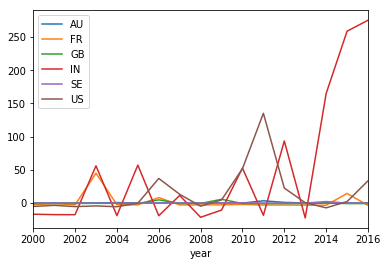

In [27]:
(hw_total_expo_by_country  / 1e6).plot()

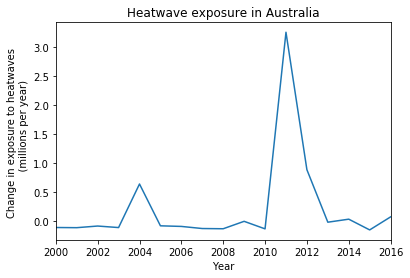

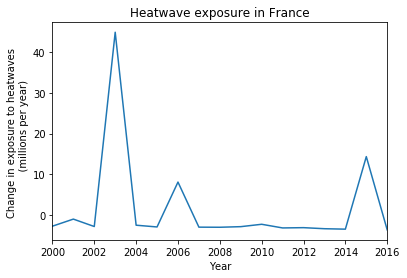

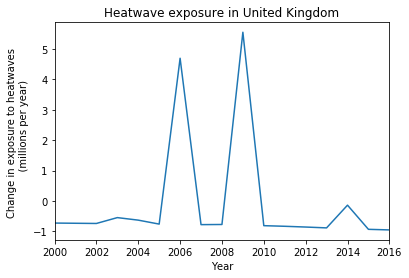

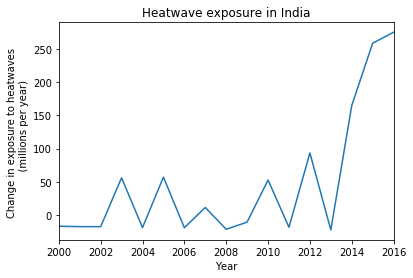

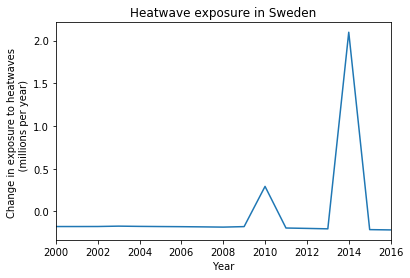

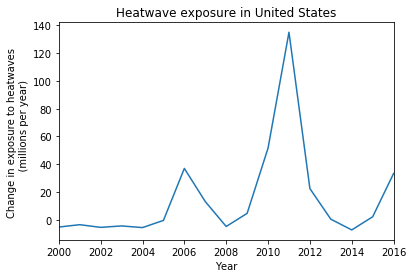

In [28]:
tmp = countries.set_index('iso_a2')
for h in hw_total_expo_by_country:
    f, ax = plt.subplots()
    (hw_total_expo_by_country[[h]] / 1e6).plot(ax=ax,legend=False)
    
    ax.set_xlabel('Year')
    ax.set_ylabel('''Change in exposure to heatwaves 
    (millions per year)''')
    country_name = tmp.loc[h]['name']
    ax.set_title(f'Heatwave exposure in {country_name}')
    
    f.savefig(str(COUNTRY_BRIEFS / 'heatwaves'  /f'{h}_heatwaves_n_exposure_2000-2016.png'), 
              dpi=300, bbox_inches='tight')




In [33]:
# hw_count_expo_by_country.to_csv('country_briefs/heatwave_count_exposure.csv')

In [73]:
# hw_count_expo_by_country = pd.read_csv('country_briefs/heatwave_count_exposure.csv', index_col='year')

In [30]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in select_country_a3]

hw_length_expo_by_country = pd.concat(results, axis=1)

In [31]:
hw_length_expo_by_country.to_csv('country_briefs/heatwaves/heatwave_mean_length_exposure.csv')

In [32]:
heatwaves_l_pop_ts = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc'))

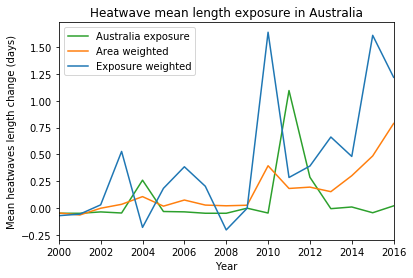

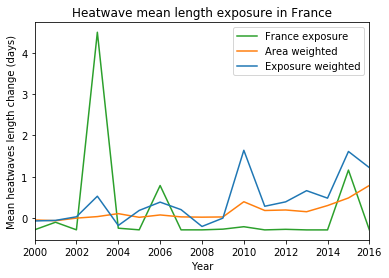

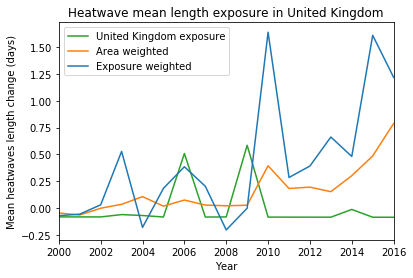

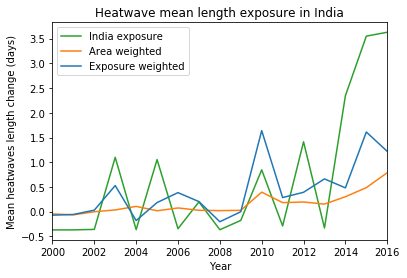

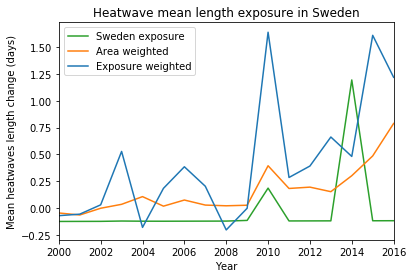

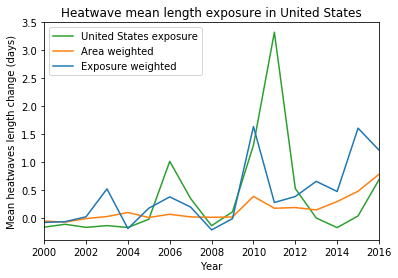

In [33]:
tmp = countries.set_index('iso_a2')
for h in hw_total_expo_by_country:
    
    country_name = tmp.loc[h]['name']
    
    f, ax = plt.subplots()
    hw_length_expo_by_country[h].plot(color='C2', ax=ax,legend=False, 
                                        label=f'{country_name} exposure')
    
    heatwaves_lengths_ts.plot(color='C1',label='Area weighted', ax=ax)
    heatwaves_l_pop_ts.plot(color='C0',label='Exposure weighted', ax=ax)

    ax.set_xlabel('Year')
    ax.set_ylabel('''Mean heatwaves length change (days)''')
    plt.legend()
    ax.set_title(f'Heatwave mean length exposure in {country_name}')
    
    f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{h}_heatwaves_mean_length_exposure_2000-2016.png'), 
              dpi=300, bbox_inches='tight')





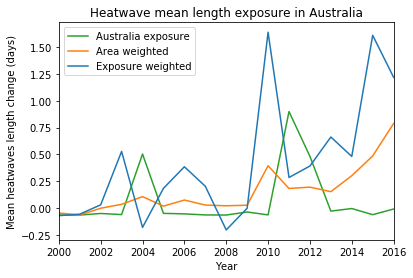

In [36]:

tmp = countries.set_index('iso_a2')
# for h in hw_total_expo_by_country:
h = 'AU'
country_name = tmp.loc[h]['name']

f, ax = plt.subplots()
hw_length_expo_by_country[h].plot(color='C2', ax=ax,legend=False, 
                                    label=f'{country_name} exposure')

heatwaves_lengths_ts.plot(color='C1',label='Area weighted', ax=ax)
heatwaves_l_pop_ts.plot(color='C0',label='Exposure weighted', ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('''Mean heatwaves length change (days)''')
plt.legend()
ax.set_title(f'Heatwave mean length exposure in {country_name}')

f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{h}_heatwaves_mean_length_exposure_2000-2016.png'), 
          dpi=300, bbox_inches='tight')






## EU zones using EU NUTS file

In [34]:
eu_nuts = geopandas.read_file(str(DATA_SRC / 'GIS' / 'NUTS_2013_10M_SH' / 'data' / 'NUTS_RG_10M_2013.shp'))
eu_nuts = eu_nuts[eu_nuts.STAT_LEVL_ == 0]
eu_codes = pd.read_csv('eu_country_codes.csv').set_index('Code')

eu_nuts = eu_codes.join(eu_nuts.set_index('NUTS_ID'))
# eu_nuts['index_number'] = np.arange(len(eu_nuts))
eu_nuts['index_number'] = 1

eu_nuts = eu_nuts.reset_index().set_index('index_number', drop=False)

In [35]:
# with population_tools.PopulationProjector('population_count_2000-2020.nc') as pop:
with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                          'water_mask_eightres.tif') as pop:
    eu_area_expo = pop.rasterize_data(eu_nuts, 'index_number', 
                                               affine=affine.Affine.translation(-180, 0) * pop.affine)

### Heatwave Counts (also non-normalised total exposure)

In [36]:
country_da = eu_area_expo.copy()
country_num = 1
eu_exposure_ts = _project_to_population(heatwaves_counts, country_da, country_num, norm=False)
eu_exposure_ts.name = 'heatwave_exposures'
eu_exposure_ts = eu_exposure_ts.to_dataframe()




In [37]:
eu_exposure_ts.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'EU28' / 'eu_heatwave_count_exposure.csv')

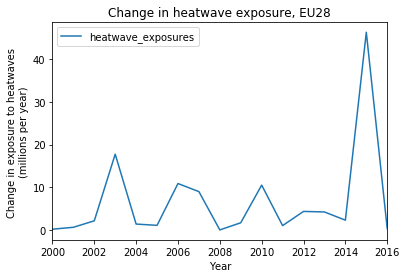

In [38]:
(eu_exposure_ts / 1e6).plot(legend=False)
plt.legend()
plt.xlabel('Year')
plt.ylabel('''Change in exposure to heatwaves 
(millions per year)''')
# plt.legend()
plt.title('Change in heatwave exposure, EU28')
plt.savefig( str(COUNTRY_BRIEFS /
                 'heatwaves' / 'EU28' / 
                 'eu_heatwaves_n_exposure_2000-2016.png'), dpi=300, bbox_inches='tight')
# plt.savefig('heatwaves_n_exposure_2000-2016.pdf', bbox_inches='tight')



### Heatwave lengths

In [44]:
country_da = eu_area_expo.copy()
country_num = 1
eu_lenghts_ts = _project_to_population(heatwaves_lengths_delta, country_da, country_num)
eu_lenghts_ts.name = 'heatwave_mean_length'
eu_lenghts_ts = eu_lenghts_ts.to_dataframe()


In [45]:
eu_lenghts_ts.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'EU28' / 'eu_heatwave_length_exposure.csv')

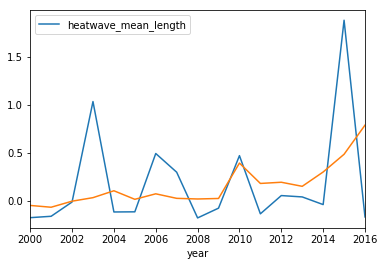

In [48]:
eu_lenghts_ts.plot()
heatwaves_lengths_ts.plot()

In [47]:
heatwaves_l_pop_ts = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc'))

In [58]:
heatwaves_l_pop_ts.to_dataframe(name='heatwave_mean_length').to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'EU28' / 'global_heatwave_length_exposure.csv')

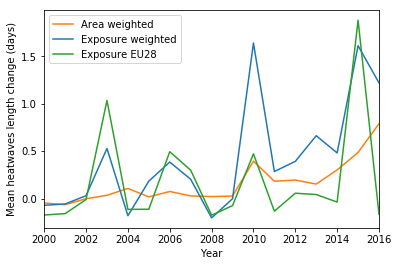

In [56]:
f, ax = plt.subplots()
heatwaves_lengths_ts.plot(color='C1',label='Area weighted', ax=ax)
heatwaves_l_pop_ts.plot(color='C0',label='Exposure weighted', ax=ax)
eu_lenghts_ts.heatwave_mean_length.plot(color='C2', label='Exposure EU28', ax=ax)



plt.xlabel('Year')
plt.ylabel('Mean heatwaves length change (days)')
plt.legend()
plt.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / 'EU28' / 'heatwaves_length_comp_2000-2016.png'), 
            dpi=300, bbox_inches='tight')
# plt.savefig('heatwaves_length_comp_2000-2016.pdf', bbox_inches='tight')




In [66]:
heatwaves_pop_events_ts = xr.open_dataarray('heatwave_exposure_events.nc')

In [67]:
heatwaves_pop_events_ts.to_dataframe(name='heatwave_exposure').to_csv(str(COUNTRY_BRIEFS / 'heatwaves' / 'global_heatwave_exposure.csv'))

## Map plots

- Need to find a 2d representation that gives a reasonable impression of the trend, with particular focus on the spatial distribution of the trend
- Especially for heatwaves which are rather random, taking the change for a single year is rather arbitrary. Instead we need to apply a reduction operation to get a 2D array from the time series
- I think doing a simple average of the total heatwave exposure change relative to the historical average should work. This gives for each pixel the average change (increase) in heat wave exposure.


UK

USA

India

France

Sweden

In [39]:
def project_heatwaves(heatwaves_delta):
    with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                          'water_mask_eightres.tif') as pop:
#         pop_sum = (pop.data * pct_age_rasters).sum(dim=['latitude', 'longitude']).compute()
        
        def _gen():
            for year in tnrange(2000, 2017):
                yield (pop.project(year, heatwaves_delta.sel(year=year)) * pct_age_rasters.sel(year=year))
        heatwaves_pop = xr.concat(_gen(), dim='year')
#         heatwaves_pop_ts = (heatwaves_pop / pop_sum).sum(dim=['latitude', 'longitude']).compute()
    return heatwaves_pop.compute()
#     return heatwaves_pop



In [40]:
heatwaves_exposure_delta = project_heatwaves(heatwaves_counts_delta)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2403: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [41]:
heatwaves_counts_delta_mean = heatwaves_counts_delta.mean(dim='year')
heatwaves_counts_delta_mean.name = 'mean_change_n_heatwaves'

In [42]:
heatwaves_exposure_delta_mean = heatwaves_exposure_delta.mean(dim='year')

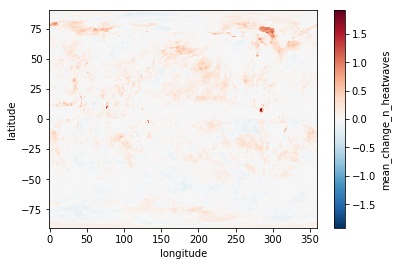

In [23]:
heatwaves_counts_delta_mean.plot()


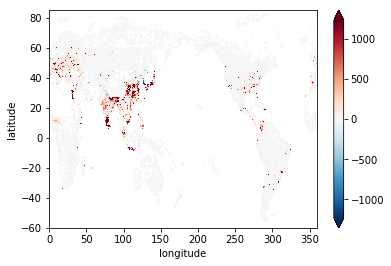

In [16]:
heatwaves_exposure_delta_mean.plot(robust=True)

In [43]:
import cartopy

In [44]:
eu_clip = geopandas.read_file(str(DATA_SRC / 'GIS' / 'world' / 'ne_50m_admin_0_countries' / 'europe-clipped.shp'))

eu_clip['index_number'] = eu_clip.index  + 1

In [18]:
select_country

['IN', 'US', 'GB', 'FR', 'SE']

In [45]:
borders = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m')

In [46]:
def plot_country(country_iso):
    if country_iso in eu_clip.adm0_a3.values:
        print(country_iso)
        tmp = eu_clip.set_index('adm0_a3')
    else:
        tmp = countries.set_index('adm0_a3')
    
    country_name = tmp.loc[country_iso]['name']
#     bounds = countries[countries.iso_a2 == country_iso].geometry.bounds.iloc[0]

    minx, miny, maxx, maxy = tmp.loc[country_iso].geometry.bounds


    bounds = (minx, maxx, miny, maxy)

    f = plt.figure(figsize=(6,3))

    ax = plt.axes(projection=ccrs.PlateCarree())
    heatwaves_exposure_delta_mean.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                                                  robust=True,
                              cbar_kwargs=dict(label='Change in exposures'),
                              cmap='RdBu_r'
                             )
    ax.coastlines()

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

    ax.set_extent(bounds)
    plt.tight_layout()
    plt.title(f'''{country_name} mean change in heatwave exposures per year
      in 2000-2016 period relative to historical average''')
    
    return f, ax
    # f.savefig('heatwaves_delta.png', dpi=300, bbox_inches='tight')




GBR
FRA
SWE


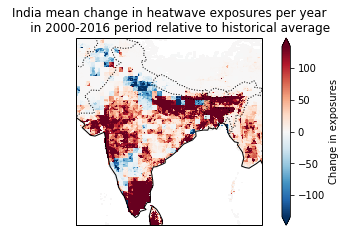

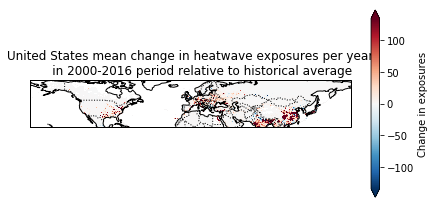

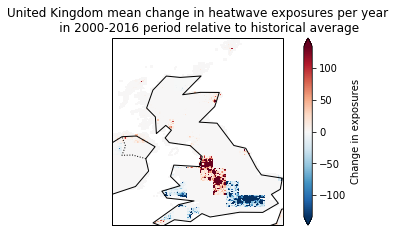

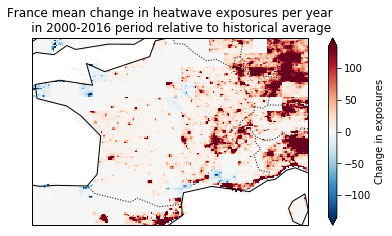

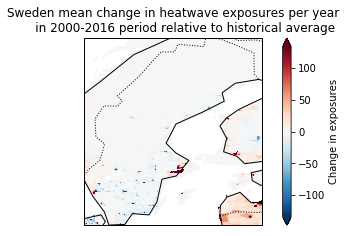

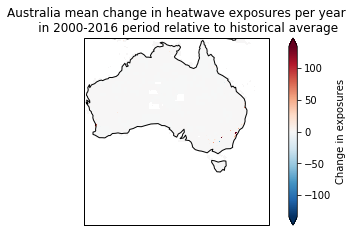

In [47]:
# TODO adjust bounds esp for france
for country_iso in select_country_a3:
    f, ax = plot_country(country_iso)
    f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')


### Do USA

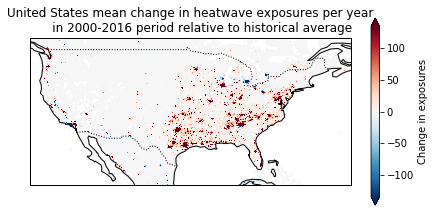

In [48]:
country_iso = 'USA'
f, ax = plot_country(country_iso)

ax.set_extent((-126.5, -62.5, 22, 47))
f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')


# -170.2,17.7,-50.6,74.1

### Do Australia

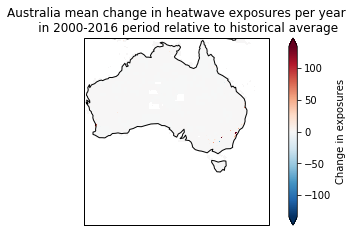

In [49]:
country_iso = 'AUS'
f, ax = plot_country(country_iso)
f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')




In [15]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo, norm=False) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in ['AUS']]

aus_hw_total_expo_by_country = pd.concat(results, axis=1)

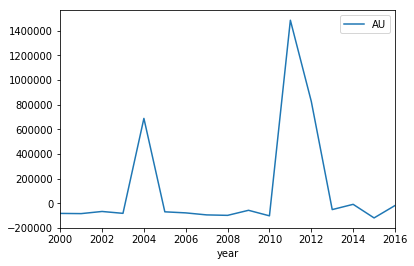

In [17]:
aus_hw_total_expo_by_country.plot()

In [18]:
aus_hw_total_expo_by_country.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'aus_total_exposure.csv')

In [13]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in ['AUS']]

aus_hw_length_expo_by_country = pd.concat(results, axis=1)

In [19]:
aus_hw_length_expo_by_country.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'aus_heatwave_mean_length_exposure.csv')